# Landsat_band_analyses.ipynb

This code uses Landsat data to calculate a variety of indices and band combinations in order to find the best measurements for determining palaeovalley locations across Australia. 

Any measurements can be done, they just need to be added to the analyses list, which makes this code versatile for many different analyses. 

Written by Claire Krause, January 2017, Datacube v 1.13

** Code dependencies **
- csv file containing the bounding boxes for the case study site/s
- palaeovalleys 2012 shape file
- Landsat band average netcdf files produced by "Extract_AGDC_for_study_sites_looped"

**Accompanying code**
- Landsat_band_analyses_looped.ipynb - The accompanying notebook loops through both sites and analyses to output multiple csv and plots of statistical difference for each case study site.


In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import geopandas as gp
import datacube
datacube.set_options(reproject_threads=1)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas
import csv
import os

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)
def write_to_csv(OUTPUT_path, row):
    if Studysite.Name == 'Blackwood2A':
        with open(OUTPUT_path,'w') as csvFile:
            writer = csv.writer(csvFile)
            header = ['name', 'ttest', 'KS_test']
            writer.writerow(header)
            writer.writerow(row)
    else:
        with open(OUTPUT_path,'a') as csvFile:
           writer = csv.writer(csvFile)
           writer.writerow(row)

## Load in our list of sites

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites_small.csv', delimiter = ',')
print(names)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

## Set up the palaeovalley 2012 mask. 
This code reads in the shapefile and identifies and lists all of the polygons witin it. For this example, we are using the 2012 Palaeovalleys shape file (see English et al. 2012)

In [4]:
shp = gp.GeoDataFrame.from_file('/g/data/p25/cek156/Palaeovalleys_2012.shp')
print (shp.head)

<bound method NDFrame.head of                                               geometry
0    POLYGON ((123.648953793 -30.56992565499991, 12...
1    (POLYGON ((117.1778376770001 -32.2709919609999...
2    POLYGON ((115.868565061 -29.73637336599995, 11...
3    POLYGON ((115.948200584 -27.86854227199996, 11...
4    POLYGON ((127.387641593 -28.59592641999996, 12...
5    POLYGON ((128.0569520910001 -28.54635345199995...
6    POLYGON ((128.698006552 -26.21770164599991, 12...
7    POLYGON ((126.722619924 -22.32913755999994, 12...
8    POLYGON ((128.3006654730001 -18.96357787199992...
9    POLYGON ((115.3584853260001 -27.20097888599992...
10   POLYGON ((126.9556900690001 -26.30121716599996...
11   POLYGON ((115.8733712540001 -25.14138591099993...
12   POLYGON ((125.9475394960001 -28.62771558199995...
13   POLYGON ((124.9745967660001 -29.53551659999994...
14   POLYGON ((120.9398331570001 -19.64230130599992...
15   POLYGON ((128.361469574 -22.02882464999993, 12...
16   POLYGON ((123.9446491120001 -3

## Choose a case study site to analyse

In [5]:
# Choose your site for this example
# Here we will select Blackwood2A, located in row 0
num = 0
Studysite = names.ix[num]
print(Studysite)

Name      Blackwood2A
minlat          -34.1
maxlat          -33.4
minlon          116.4
maxlon          117.4
Name: 0, dtype: object


## Read in the data for our study site

In [6]:
blue = xr.open_dataset('/g/data/p25/cek156/' + Studysite.Name + '/' + Studysite.Name + '_blue_time_mean.nc')
green = xr.open_dataset('/g/data/p25/cek156/' + Studysite.Name + '/' + Studysite.Name + '_green_time_mean.nc')
red = xr.open_dataset('/g/data/p25/cek156/' + Studysite.Name + '/' + Studysite.Name + '_red_time_mean.nc')
nir = xr.open_dataset('/g/data/p25/cek156/' + Studysite.Name + '/' + Studysite.Name + '_nir_time_mean.nc')
swir1 = xr.open_dataset('/g/data/p25/cek156/' + Studysite.Name + '/' + Studysite.Name + '_swir1_time_mean.nc') 
swir2 = xr.open_dataset('/g/data/p25/cek156/' + Studysite.Name + '/' + Studysite.Name + '_swir2_time_mean.nc')

# List which analyses we would like to do

Check out http://www.indexdatabase.de/db/i.php for a list of a whole bunch of indices, as well as their platform specific formulas (if you click on the index name).

In [7]:
only_blue = blue.blue
only_green = green.green
only_red = red.red
only_nir = nir.nir
only_swir1 = swir1.swir1
only_swir2 = swir2.swir2
SAVI = (((nir.nir - red.red) / (nir.nir + red.red + 0.5))*(1 + 0.5)) #Soil adjusted vegetation index, where L = 0.5
FalseCol = ((nir.nir + red.red + green.green)) #False colour
RealCol = ((red.red + green.green + blue.blue)) #Real colour
gNDVI = ((nir.nir - green.green) / (nir.nir + green.green)) #green NDVI
NDMI = ((nir.nir - swir1.swir1) / (nir.nir + swir1.swir1)) #normalised difference moisture index

## Calculate the statistics for each site

Loop through each case study site, apply the palaeovalleys 2012 mask, calculate the statistical difference in values inside and outside the masked areas, then write the results to a csv file.

We will just do one analysis for demonstration purposes. The accompanying looped analyses will analyse all of the analyses you provide and output to different csv files.

In [8]:
# Set up the paths to the output file
OUTPUT = '/g/data/p25/cek156/only_blue_stats.csv'

# Create a bounding box from the locations specified above
box = shapely.geometry.box(names.minlon[num], names.minlat[num], names.maxlon[num], names.maxlat[num], ccw = True)
# Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
filtered = shp.where(shp.intersects(box)).dropna()
# Combine all of the relevant polygons into a single polygon
shp_union = shapely.ops.unary_union(filtered.geometry)

data = only_blue

# Check for the geobox attribute. If it's not there, apply it from the datacube.
if not hasattr(data, 'geobox'):
    query = {'time': ('2000-01-01', '2000-01-31'),
             'lat': (names.maxlat[num], names.minlat[num]), 
             'lon': (names.minlon[num], names.maxlon[num]), 
             'resolution': (-250, 250)}
    bands_of_interest = ['red']                         
    dc = datacube.Datacube(app='hack')
    nbar = dc.load(product = 'ls7_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    print('Applying datacube geobox')
    geobox = nbar.geobox
    data.attrs['geobox'] = geobox
# Create the mask based on our shapefile
mask = geometry_mask(warp_geometry(shp_union, shp.crs, blue.crs), data.geobox, invert=True)

Applying datacube geobox


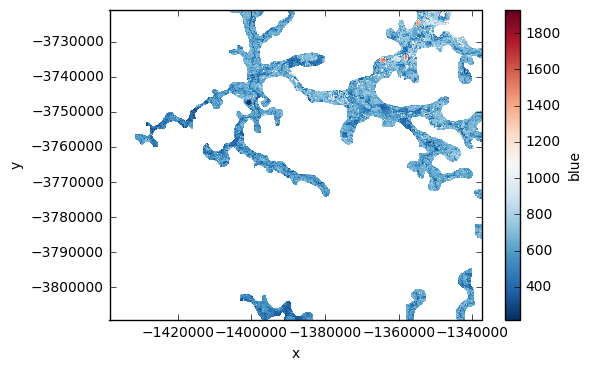

In [9]:
# Get data only inside the mask
data_masked = data.where(mask)
# Plot the masked dataset
fig = data_masked.plot(cmap = 'RdBu_r')

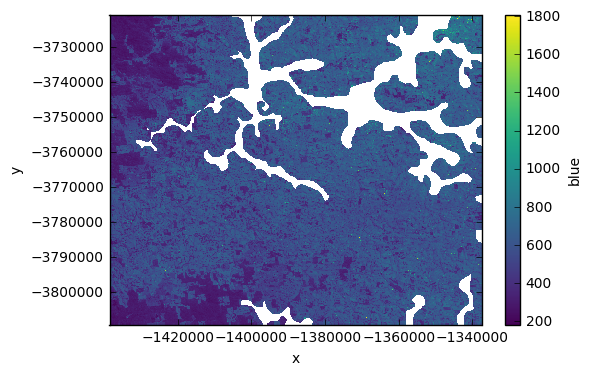

In [10]:
# Get data only where the mask is 'false'
data_maskedF = data.where(~ mask)
# Plot the opposite masked dataset
fig = data_maskedF.plot()

(array([  2.00000000e+00,   1.50000000e+01,   1.05000000e+02,
          9.02000000e+02,   2.61100000e+03,   3.77000000e+03,
          3.77700000e+03,   3.55800000e+03,   3.32600000e+03,
          3.13600000e+03,   3.15800000e+03,   3.32800000e+03,
          3.79500000e+03,   4.18800000e+03,   4.76400000e+03,
          5.38200000e+03,   6.67100000e+03,   8.14700000e+03,
          1.00900000e+04,   1.11060000e+04,   1.13160000e+04,
          9.73900000e+03,   7.35800000e+03,   4.86600000e+03,
          3.05100000e+03,   1.78100000e+03,   1.18200000e+03,
          7.26000000e+02,   4.98000000e+02,   3.21000000e+02,
          2.56000000e+02,   1.53000000e+02,   1.21000000e+02,
          1.08000000e+02,   8.00000000e+01,   5.90000000e+01,
          4.20000000e+01,   3.80000000e+01,   3.40000000e+01,
          2.80000000e+01,   2.30000000e+01,   1.30000000e+01,
          1.30000000e+01,   9.00000000e+00,   6.00000000e+00,
          1.50000000e+01,   9.00000000e+00,   6.00000000e+00,
        

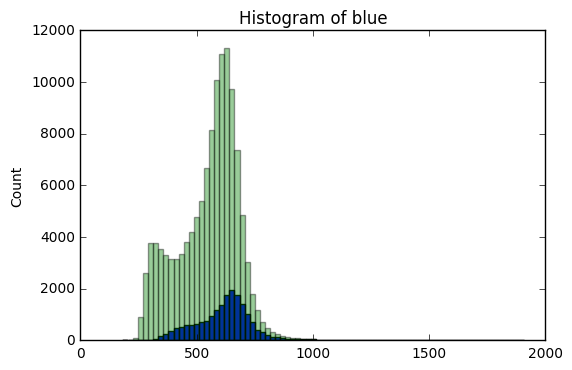

In [11]:
minval = data.min()
maxval = data.max()
bin_values = np.arange(start = minval, stop = maxval, step = ((maxval - minval)/80))
data_masked.plot.hist(bins = bin_values)
data_maskedF.plot.hist(alpha = 0.4, bins = bin_values)

In [12]:
# Create a new numpy array with just the values
data_masked2 = np.array(data_masked)
data_maskedF2 = np.array(data_maskedF)

# Remove nan values
data_masked_nonan = data_masked2[~np.isnan(data_masked2)]
data_maskedF_nonan = data_maskedF2[~np.isnan(data_maskedF2)]
print(data_masked_nonan)
print(data_maskedF_nonan)

[ 643.94832041  617.05867347  576.87371134 ...,  704.23655914  553.86740331
  596.64324324]
[ 545.35748792  543.12315271  283.02525253 ...,  672.11794872  688.765625
  559.75634518]


[array([ 643.94832041,  617.05867347,  576.87371134, ...,  704.23655914,
        553.86740331,  596.64324324]), array([ 545.35748792,  543.12315271,  283.02525253, ...,  672.11794872,
        688.765625  ,  559.75634518])]
[19291, 123725]
Ttest_indResult(statistic=69.995973291495091, pvalue=0.0)
Ks_2sampResult(statistic=0.20833016136318194, pvalue=0.0)


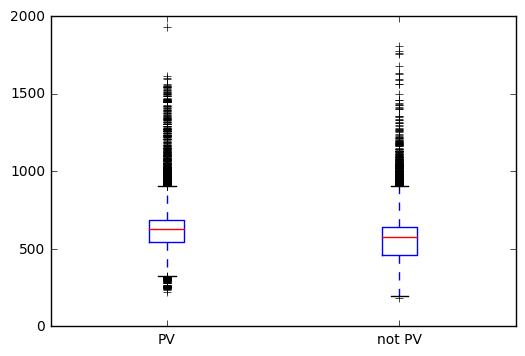

In [13]:
masked_both = [data_masked_nonan,data_maskedF_nonan]
print(masked_both)
# How many data points are in each of my lists?
size = ([len(i) for i in masked_both])
print(size)

bp = plt.boxplot(masked_both)
plt.xticks([1,2],['PV', 'not PV'])

stats_ttest = scipy.stats.ttest_ind(data_masked_nonan,data_maskedF_nonan, equal_var = 'False')
print(stats_ttest)

# Test with a Kolmogorov-Smirnov test 
# Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
stats_KS = scipy.stats.ks_2samp(data_masked_nonan,data_maskedF_nonan)
print(stats_KS)